# Replicating _Intermediary asset pricing: New evidence from many asset classes_
### James, Young Jin Song, Jaehwa Youm, Monica Panigrahy, and Jacob Simeral 

In [5]:
import pandas as pd
import wrds
import config
from datetime import datetime
import unittest
import matplotlib.pyplot as plt
import numpy as np
import Table02Analysis
import Table02Prep
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Table 01

### Table A.1

### Table 02

The following code reads in a manual data file that contains necessary information on primary dealers from 1960-2012 and then merges it with the CRSP Compustat Merge Linkhist table to get additional information on each, such as the SIC codes. The linkhist table is also used as the main reference table to pull the other comparison groups for the table.

In [6]:
db = wrds.Connection(wrds_username=config.WRDS_USERNAME)
merged_main, link_hist = Table02Prep.prim_deal_merge_manual_data_w_linktable()
merged_main

Loading library list...
Done


,gvkey,conm,sic,Start Date,End Date
0,15504,ABN-AMRO HOLDINGS NV,6020,9/29/1998,9/15/2006
11,3243,CITIGROUP INC,6199,5/19/1960,4/17/2000
38,3243,CITIGROUP INC,6199,6/15/1961,Current
65,7647,BANK OF AMERICA CORP,6020,4/18/1994,9/30/1997
106,7647,BANK OF AMERICA CORP,6020,11/17/1971,4/15/1994
...,...,...,...,...,...
1791,1414,PRIMERICA INC,6311,8/22/1979,8/31/1998
1822,9577,SECURITY PACIFIC CORP,6020,12/11/1986,1/17/1991
1842,2612,CALIFORNIA FED BANCORP INC,6035,6/7/1983,8/5/1983
1855,15706,TORONTO DOMINION BANK,6020,2/11/2014,Current


As mentioned above, the next step is now to use the linkhist table to determine what the other comparison groups are. We use SIC codes to determine broker dealers and banks, and we make sure to exclude any firms that are already in the primary dealer group so we do not have duplicates. Below is the reference table for broker dealers, which had explicit SIC codes mentioned in the paper - banks did not have explicit SIC codes mentioned and required research.

In [7]:
comparison_group_link_dict = Table02Prep.create_comparison_group_linktables(link_hist, merged_main)
comparison_group_link_dict['PD']

,gvkey,conm,sic,Start Date,End Date
0,15504,ABN-AMRO HOLDINGS NV,6020,9/29/1998,9/15/2006
11,3243,CITIGROUP INC,6199,5/19/1960,4/17/2000
38,3243,CITIGROUP INC,6199,6/15/1961,Current
65,7647,BANK OF AMERICA CORP,6020,4/18/1994,9/30/1997
106,7647,BANK OF AMERICA CORP,6020,11/17/1971,4/15/1994
...,...,...,...,...,...
1791,1414,PRIMERICA INC,6311,8/22/1979,8/31/1998
1822,9577,SECURITY PACIFIC CORP,6020,12/11/1986,1/17/1991
1842,2612,CALIFORNIA FED BANCORP INC,6035,6/7/1983,8/5/1983
1855,15706,TORONTO DOMINION BANK,6020,2/11/2014,Current


We then used each of the reference tables (primary dealers, broker dealers, banks, all firms in Compustat) and pulled data from the Compustat Fundamentals Annual table. The paper mentioned use of monthly data, but there was no apparent monthly table for financial statement data from Compustat. This led to some confusion about how these authors generated their ratios - I am wondering if they computed monthly ratios given what months came out of annual and then took the average. The annuals data did come out in a strange format, however, where it seemed like there was data for several months of the year with disproportionate amounts in each month. The quarterly dataset was not used because it did not appear to have the same gvkey compatibility as the annual table.

![title](img/table02_annuals_dataset.png)

Below is the dataset for broker dealers. We calculate or directly pull the values we need in our query so we don't need to do it after. It was mentioned in class this was a best practice because it would run on WRDS servers.

In [8]:
datasets = Table02Prep.pull_data_for_all_comparison_groups(db, comparison_group_link_dict)
datasets['PD']

,datadate,total_assets,book_debt,book_equity,market_equity,gvkey,conm
0,1998-12-31,503934.903,487312.516,12505.425,31278.675000,015504,ABN-AMRO HOLDINGS NV
1,1999-12-31,461089.000,444038.000,12071.000,37162.800000,015504,ABN-AMRO HOLDINGS NV
2,2000-12-31,509927.000,493207.000,11757.000,34177.370500,015504,ABN-AMRO HOLDINGS NV
3,2001-12-31,531713.000,517166.000,10492.000,24997.940000,015504,ABN-AMRO HOLDINGS NV
4,2002-12-31,582984.873,567686.209,11303.879,25655.008000,015504,ABN-AMRO HOLDINGS NV
...,...,...,...,...,...,...,...
4,1997-12-31,88540.188,81518.000,7022.199,29396.486250,008007,WELLS FARGO & CO
5,1998-12-31,202475.000,181716.000,20759.000,65659.566375,008007,WELLS FARGO & CO
6,1999-12-31,218102.000,195971.000,22131.000,65785.706438,008007,WELLS FARGO & CO
7,2000-12-31,272426.000,245938.000,26488.000,95484.349125,008007,WELLS FARGO & CO


We then prep that data further by aggregating by year and standardizing the date to the first of the year. We also convert the datadate to a datetime column that can be sliced.

In [9]:
prepped_datasets = Table02Prep.prep_datasets(datasets)
prepped_datasets['Banks']

,datadate,total_assets,book_debt,book_equity,market_equity
0,1960-01-01,7.515993e+04,3.841206e+04,6071.847,0.000000e+00
1,1961-01-01,8.230766e+04,3.958452e+04,6540.672,0.000000e+00
2,1962-01-01,8.833427e+04,4.502994e+04,6895.387,1.049351e+04
3,1963-01-01,1.219723e+05,1.114317e+05,9300.422,1.182642e+04
4,1964-01-01,1.363716e+05,1.248879e+05,10018.281,1.247930e+04
5,1965-01-01,1.521872e+05,1.397237e+05,10746.259,1.151586e+04
6,1966-01-01,1.655932e+05,1.518739e+05,11307.324,1.306373e+04
7,1967-01-01,1.915728e+05,1.765848e+05,12128.945,1.438679e+04
8,1968-01-01,2.163426e+05,2.002108e+05,13029.328,2.086249e+04
9,1969-01-01,2.396760e+05,2.224958e+05,14334.997,1.964492e+04


We then weave in some of our analysis into the process, whenever the necessary dataset for the analysis is first available. Below is our main table of ratios, where we have computed the
$$
\frac{\text{Primary dealers amount}}{\text{Comparison group amount (less PD) + Primary dealers amount}}
$$

In [10]:
Table02Analysis.create_summary_stat_table_for_data(datasets)
table = Table02Prep.create_ratios_for_table(prepped_datasets)
table

,total_assets_BD,book_debt_BD,book_equity_BD,market_equity_BD,total_assets_Banks,book_debt_Banks,book_equity_Banks,market_equity_Banks,total_assets_Cmpust.,book_debt_Cmpust.,book_equity_Cmpust.,market_equity_Cmpust.,Period
datadate,,,,,,,,,,,,,
1960-01-01,0.994757,0.996001,1.000000,NaN,0.140385,0.165996,0.145801,NaN,0.031971,0.057844,0.084328,0.000000,1960-2012
1961-01-01,0.994551,0.995342,1.000000,1.000000,0.142919,0.177522,0.142709,1.000000,0.032679,0.048629,0.028546,0.050405,1960-2012
1962-01-01,0.960115,0.942576,0.980093,1.000000,0.139781,0.163534,0.142141,0.188113,0.031126,0.044425,0.018469,0.007528,1960-2012
1963-01-01,0.961861,0.960954,0.986783,1.000000,0.114348,0.110362,0.158578,0.174051,0.029983,0.049020,0.010599,0.006545,1960-2012
1964-01-01,0.970309,0.969816,0.989365,1.000000,0.146532,0.143243,0.180582,0.213996,0.039711,0.064672,0.011767,0.007484,1960-2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-01,0.988118,0.988940,0.974278,0.949269,0.651731,0.657129,0.552204,0.450868,0.310649,0.352854,0.088010,0.032344,1990-2012
2009-01-01,0.985530,0.986542,0.969728,0.961018,0.611995,0.614747,0.573490,0.547569,0.282737,0.324274,0.093529,0.049301,1990-2012
2010-01-01,0.985386,0.986343,0.971153,0.958730,0.625092,0.628888,0.571621,0.539365,0.274330,0.314789,0.093174,0.045699,1990-2012


We create a figure that can give the reader insight into how the ratios have shifted over time for each category and comparison group. We had to clean some of the data and fill null values to have the graph look reasonable but without changing the overall shape of it too dramatically.

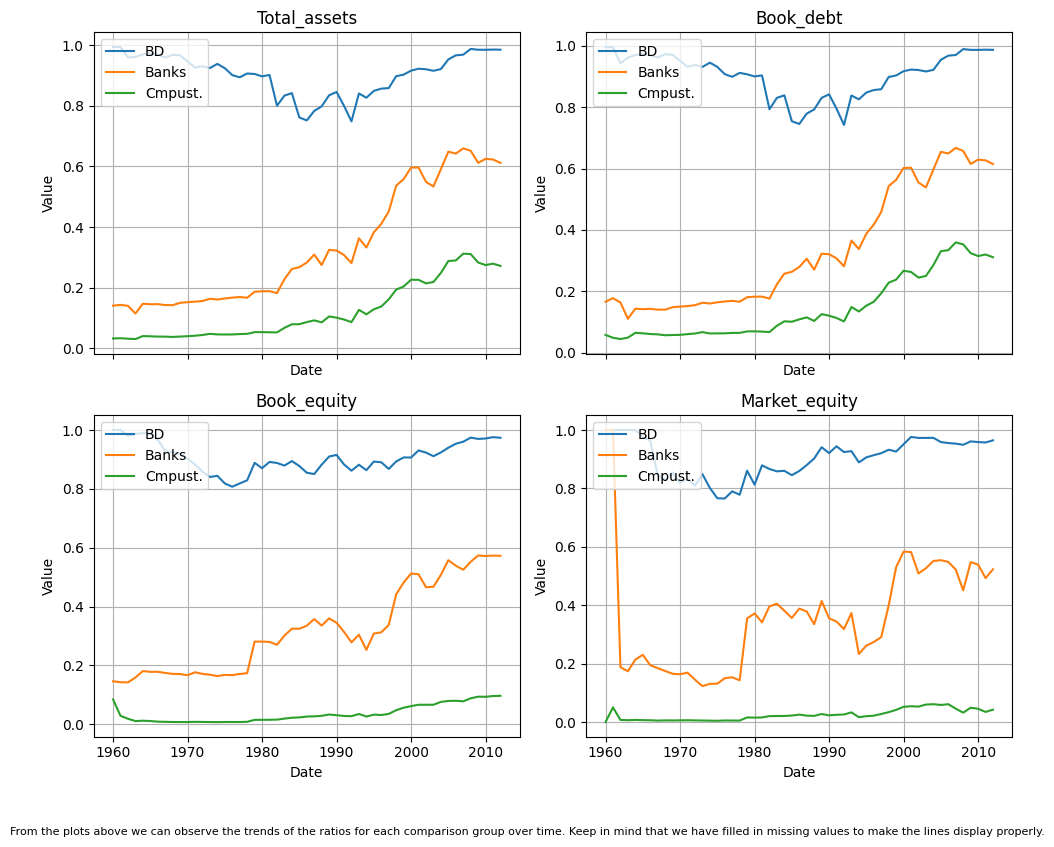

In [11]:
Table02Analysis.create_figure_for_data(table)

Lastly, we get our final table which was what we were trying to replicate from the paper. This table is then converted to LaTeX and outputted to a .tex file.

In [12]:
formatted_table = Table02Prep.format_final_table(table)
formatted_table

Metric    Total assets                     Book debt                      \
Source              BD     Banks   Cmpust.        BD     Banks   Cmpust.   
Period                                                                     
1960-2012     0.905254  0.328967  0.119626  0.904850  0.331127  0.145254   
1960-1990     0.902443  0.189391  0.053495  0.902264  0.189797  0.073100   
1990-2012     0.906469  0.516800  0.207932  0.905580  0.521165  0.241427   

Metric    Book equity                     Market equity                      
Source             BD     Banks   Cmpust.            BD     Banks   Cmpust.  
Period                                                                       
1960-2012    0.908294  0.319144  0.035655      0.903077  0.351491  0.024603  
1960-1990    0.899557  0.224465  0.017193      0.872328  0.277292  0.013032  
1990-2012    0.920375  0.447867  0.060320      0.943962  0.448443  0.040139

Loading library list...
Done


Metric    Total assets                     Book debt                      \
Source              BD     Banks   Cmpust.        BD     Banks   Cmpust.   
Period                                                                     
1960-2024     0.918636  0.374005  0.140897  0.918419  0.376174  0.168007   
1960-1990     0.902443  0.189391  0.053127  0.902264  0.189797  0.072512   
1990-2024     0.931266  0.540808  0.219708  0.930886  0.544477  0.253636   

Metric    Book equity                     Market equity                      
Source             BD     Banks   Cmpust.            BD     Banks   Cmpust.  
Period                                                                       
1960-2024    0.919675  0.361316  0.045865      0.911581  0.386589  0.027210  
1960-1990    0.899557  0.224465  0.017137      0.872328  0.277292  0.013028  
1990-2024    0.937890  0.485604  0.071607      0.946492  0.482110  0.040023

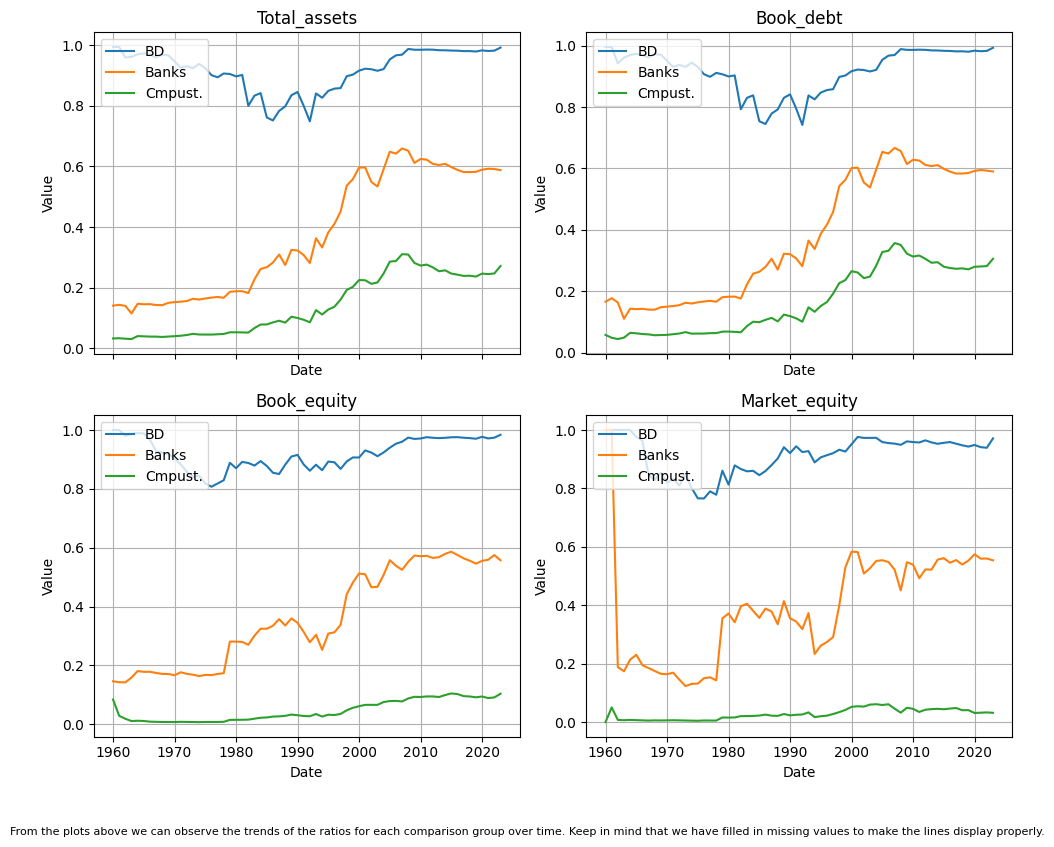

In [4]:
updated_table = Table02Prep.main(UPDATED=True)
updated_table

### Table 03